# Code

## Section 1: Setup environment (15 points in total)

### Q3: Install DBT using Miniconda (0.5 points)

In [1]:
! which dbt

/home/badri/miniconda3/envs/p4-env/bin/dbt


### Q9: Use dbt to transform the column names to single word or two-word names with "_" separator and create a view named survey_transformed. (4 points)

In [1]:
! grep -v 'password' ~/.dbt/profiles.yml

p4_data_pipeline:
  outputs:
    dev:
      account: zmlqfxg-sb16509
      database: SURVEY_DATABASE
      role: P4_ROLE
      schema: SURVEY_SCHEMA
      threads: 1
      type: snowflake
      user: bmuralikrish
      warehouse: P4_WAREHOUSE
  target: dev


In [2]:
! cat ~/p4_data_pipeline/models/schema.yml

version: 2

sources:
  - name: P4
    database: SURVEY_DATABASE
    schema: SURVEY_SCHEMA
    tables:
      - name: SURVEY

models:
  - name: transform_survey
    description: "Cleaned and renamed survey data"



In [3]:
! cat ~/p4_data_pipeline/models/staging/transform_survey.sql

with transformed_survey as (
  select
    "TIMESTAMP",
    "EMAIL_ADDRESS" as email_address,
    "WHAT_IS_YOUR_AGE_" as age,
    "WHAT_IS_YOUR_FAVORITE_HOBBY_" as favorite_hobby,
    "WHAT_IS_YOUR_CURRENT_STANDING" as academic_standing,
    "WHAT_IS_YOUR_FAVORITE_PIZZA_TOPPING_" as favorite_pizza_topping,
    "HAVE_YOU_EVER_IN_YOUR_LIFE_HAD_A_PET_" as has_had_pet,
    "DO_YOU_CONSIDER_YOURSELF_A_PROCRASTINATOR_" as procrastinator,
    "WHAT_FACTOR_INFLUENCES_YOUR_COURSE_SELECTION_THE_MOST_" as course_selection_factor,
    "IF_YOU_HAD_AN_EXTRA_HOUR_IN_YOUR_DAY_HOW_WOULD_YOU_SPEND_IT_" as extra_hour_activity,
    "WOULD_YOU_DESCRIBE_YOURSELF_AS_AN_EARLY_BIRD_OR_A_NIGHT_OWL_" as sleep_rhythm,
    "ARE_YOU_A_RUNNER_CONSIDER_BOTH_RUNNING_ON_TREADMILL_AND_OUTDOORS_" as runner,
    "IF_YOU_HAVE_SECONDARY_MAJORS_PLEASE_LIST_THEM_HERE_SEPARATED_BY_A_COMMA_" as secondary_majors,
    "WHICH_BEST_DESCRIBES_YOUR_PRIMARY_MAJOR_OR_FIELD_OF_STUDY_IF_YOU_HAVE_MORE_THAN_ONE_MAJOR_PLEASE_SPECIFY_OTHER_MA

## Section 2: Custom student dataset analysis (7 points in total)

## Imports & Snowflake Connection

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import snowflake.connector

In [2]:
with open("snowflake_password.txt", "r") as file:
    snowflake_password = file.read()
    snowflake_password = snowflake_password.strip()

In [3]:
connector = snowflake.connector.connect(
    user="bmuralikrish",
    password=snowflake_password,
    account="zmlqfxg-sb16509",
    warehouse="P4_WAREHOUSE",
    database="STOCK_DB",
    schema="STOCK_SCHEMA",
    role="P4_ROLE",
)

### Q10: How many students are in each academic standing? (1 point)

In [4]:
query = """
SELECT 
    ACADEMIC_STANDING, 
    COUNT(*) AS count
FROM SURVEY_DATABASE.SURVEY_SCHEMA.TRANSFORM_SURVEY
GROUP BY ACADEMIC_STANDING
ORDER BY count DESC;
"""
df = pd.read_sql(query, connector)
df

/tmp/ipykernel_353868/2111847130.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connector)


,ACADEMIC_STANDING,COUNT
0,Senior,67
1,Junior,50
2,Sophomore,23
3,Grad,19


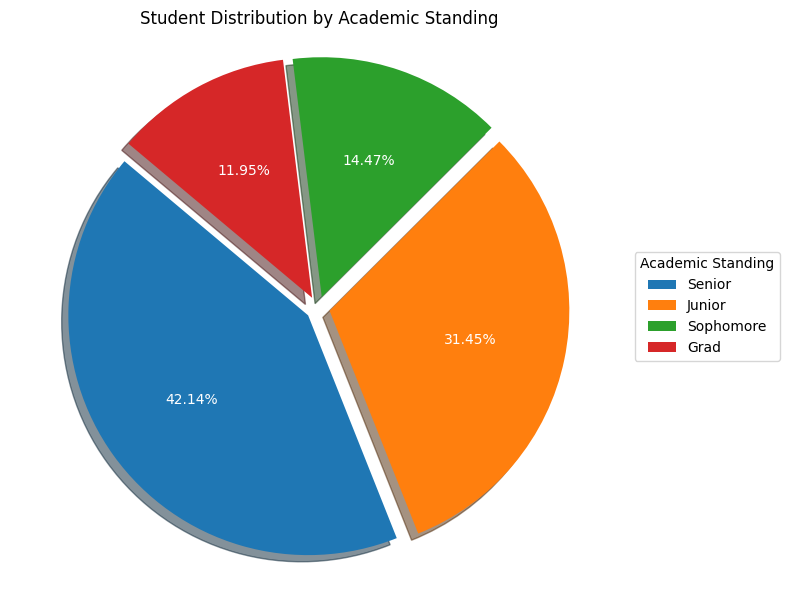

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))
wedges, texts, autotexts = ax.pie(
    df["COUNT"],
    labels=df["ACADEMIC_STANDING"],
    autopct="%1.2f%%",
    explode=[0.05] * len(df),
    shadow=True,
    startangle=140,
    textprops=dict(color="white"),
)
ax.legend(
    wedges,
    df["ACADEMIC_STANDING"],
    title="Academic Standing",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
)
ax.axis("equal")
plt.title("Student Distribution by Academic Standing")
plt.tight_layout()
plt.show()

### Q11: What is the average age of students in each academic standing? (1 point)

In [6]:
query = """
SELECT 
    ACADEMIC_STANDING, 
    AVG(CAST(AGE AS FLOAT)) AS avg_age
FROM SURVEY_DATABASE.SURVEY_SCHEMA.TRANSFORM_SURVEY
GROUP BY ACADEMIC_STANDING
ORDER BY avg_age DESC;
"""
df = pd.read_sql(query, connector)
df

/tmp/ipykernel_353868/2498772714.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connector)


,ACADEMIC_STANDING,AVG_AGE
0,Grad,24.421053
1,Senior,21.552239
2,Junior,20.560000
3,Sophomore,19.956522


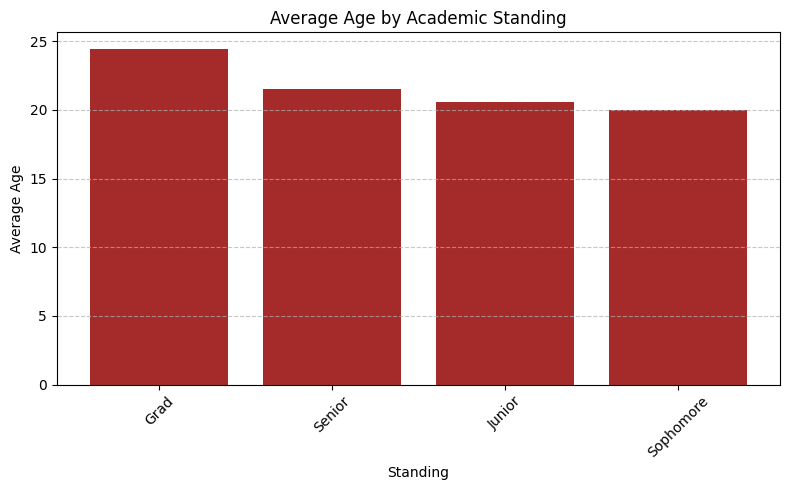

In [7]:
plt.figure(figsize=(8, 5))
plt.bar(df["ACADEMIC_STANDING"], df["AVG_AGE"], color="brown")
plt.title("Average Age by Academic Standing")
plt.xlabel("Standing")
plt.ylabel("Average Age")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

### Q12: What percentage of students would choose to sleep if they had an extra hour in their day? (1 point)

In [8]:
query = """
SELECT
  ROUND(
    100.0 * COUNT_IF(EXTRA_HOUR_ACTIVITY = 'Sleeping')
    / COUNT(*),
    2
  ) AS sleep_percentage
FROM SURVEY_DATABASE.SURVEY_SCHEMA.TRANSFORM_SURVEY;
"""
df = pd.read_sql(query, connector)
df

/tmp/ipykernel_353868/3481716600.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connector)


,SLEEP_PERCENTAGE
0,27.04


### Q13: What is the academic standing and course selection factor of the student with email `bmuralikrish@wisc.edu`? (1 point)

In [9]:
query = """
SELECT
    EMAIL_ADDRESS,
    ACADEMIC_STANDING,
    COURSE_SELECTION_FACTOR
FROM SURVEY_DATABASE.SURVEY_SCHEMA.TRANSFORM_SURVEY
WHERE EMAIL_ADDRESS = 'bmuralikrish@wisc.edu';
"""
df = pd.read_sql(query, connector)
df

/tmp/ipykernel_353868/3580348317.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connector)


,EMAIL_ADDRESS,ACADEMIC_STANDING,COURSE_SELECTION_FACTOR
0,bmuralikrish@wisc.edu,Grad,Interest in the subject


### Q14: How many students have a secondary major? (1 point)

In [10]:
query = """
SELECT
  CASE
    WHEN SECONDARY_MAJORS IS NULL
    THEN 'No'
    ELSE 'Yes'
  END AS SECONDARY_MAJOR,
  COUNT(*) AS count
FROM SURVEY_DATABASE.SURVEY_SCHEMA.TRANSFORM_SURVEY
GROUP BY SECONDARY_MAJOR;
"""
df = pd.read_sql(query, connector)
df

/tmp/ipykernel_353868/3360770553.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connector)


,SECONDARY_MAJOR,COUNT
0,No,93
1,Yes,66


### Q15: What are the top 5 most common ZIP codes among students? (1 point)

In [11]:
query = """
SELECT 
  ZIP_CODE,
  COUNT(*) AS count
FROM SURVEY_DATABASE.SURVEY_SCHEMA.TRANSFORM_SURVEY
GROUP BY ZIP_CODE
ORDER BY count DESC
LIMIT 5;
"""
df = pd.read_sql(query, connector)
df

/tmp/ipykernel_353868/3519494612.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connector)


,ZIP_CODE,COUNT
0,53703,68
1,53715,48
2,53706,11
3,53705,8
4,53711,7


### Q16: How do Night Owls prefer to spend an extra hour in their day? (1 point)

In [12]:
query = """
SELECT 
    EXTRA_HOUR_ACTIVITY, 
    COUNT(*) AS count
FROM SURVEY_DATABASE.SURVEY_SCHEMA.TRANSFORM_SURVEY
WHERE SLEEP_RHYTHM = 'night owl'
GROUP BY EXTRA_HOUR_ACTIVITY
ORDER BY count DESC;
"""
df = pd.read_sql(query, connector)
df

/tmp/ipykernel_353868/2564664899.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connector)


,EXTRA_HOUR_ACTIVITY,COUNT
0,Sleeping,34
1,Working on a hobby,24
2,Exercising,19
3,Playing video games,15
4,Reading for fun,9


## Section 3: Stock and foreign exchange (fx) dataset analysis (7 points in total)

### Q18: Configure ~/.dbt/profiles.yml for STOCK_DB (0.5 points)

In [1]:
! grep -v 'password' ~/.dbt/profiles.yml

p4_data_pipeline:
  outputs:
    dev:
      type: snowflake
      account: zmlqfxg-sb16509
      user: bmuralikrish
      role: P4_ROLE
      database: SURVEY_DATABASE
      warehouse: P4_WAREHOUSE
      schema: SURVEY_SCHEMA
      threads: 1

    stock_db:
      type: snowflake
      account: zmlqfxg-sb16509
      user: bmuralikrish
      role: P4_ROLE
      database: STOCK_DB
      warehouse: P4_WAREHOUSE
      schema: STOCK_SCHEMA
      threads: 1

  target: dev


### Q19: Update models/schema.yml file to include new sources for STOCK_DB tables (0.5 points)

In [2]:
! cat ~/p4_data_pipeline/models/schema.yml

version: 2

sources:
  - name: P4
    database: SURVEY_DATABASE
    schema: SURVEY_SCHEMA
    tables:
      - name: SURVEY

  - name: stock_by_day
    database: STOCK_TRACKING_DB
    schema: STOCK
    tables:
      - name: US_STOCK_METRICS

  - name: fx_by_day
    database: FOREX_DB
    schema: STOCK
    tables:
      - name: FOREX_METRICS

  - name: airbyte_csv_data
    database: STOCK_DB
    schema: STOCK_SCHEMA
    tables:
      - name: TRADING_BOOKS
      - name: WEIGHTS_TABLE

models:
  - name: transform_survey
    description: "Cleaned and renamed survey data"



### Q20: Create dbt_project.yml file in your dbt project directory --- p4_data_pipeline (0.5 points)

In [13]:
! cat ~/p4_data_pipeline/dbt_project.yml

name: 'p4_data_pipeline'
version: '1.0'
config-version: 2

profile: 'p4_data_pipeline'

model-paths: ["models"]
analysis-paths: ["analysis"]
test-paths: ["tests"]
seed-paths: ["data"]
macro-paths: ["macros"]

models:
  p4_data_pipeline:
    staging:
      materialized: view
      +warehouse: P4_WAREHOUSE
    marts:
      materialized: table
      +warehouse: P4_WAREHOUSE



### Q21: Creating staging tables for FX and Stock (1 point)

In [14]:
! cat ~/p4_data_pipeline/models/staging/staging_valid_stock_tickers.sql

select distinct
    ticker,
    trade_date as date
from {{ source('airbyte_csv_data', 'TRADING_BOOKS') }}
where desk = 'Equity Desk'


In [15]:
! cat ~/p4_data_pipeline/models/staging/staging_valid_fx_tickers.sql

select distinct
    ticker,
    trade_date as date
from {{ source('airbyte_csv_data', 'TRADING_BOOKS') }}
where desk = 'FX Desk'


In [16]:
! cat ~/p4_data_pipeline/models/staging/staging_valid_stock_info.sql

select
    a.ticker,
    a.date,
    b."OPEN" as open,
    b."CLOSE" as close,
    b."HIGH" as high,
    b."LOW" as low
from {{ ref('staging_valid_stock_tickers') }} a
join {{ source('stock_by_day', 'US_STOCK_METRICS') }} b
on a.ticker = b."TICKER" and a.date = b."RUN_DATE"



In [17]:
! cat ~/p4_data_pipeline/models/staging/staging_valid_fx_info.sql

select
    a.ticker,
    a.date,
    b."OPEN" as open,
    b."CLOSE" as close,
    b."HIGH" as high,
    b."LOW" as low
from {{ ref('staging_valid_fx_tickers') }} a
join {{ source('fx_by_day', 'FOREX_METRICS') }} b
on a.ticker = b."CURRENCY_PAIR_NAME" and a.date = b."RUN_DATE"


### Q22: Create staging table for trading pairs (0.5 points)

In [18]:
! cat ~/p4_data_pipeline/models/staging/staging_buy_sell_joint.sql

SELECT
  buy.TRADE_ID AS trade_id,
  buy.TRADE_DATE AS trade_date,
  buy.TRADER_NAME AS trader_name,
  buy.DESK AS desk,
  buy.TICKER AS ticker,
  buy.QUANTITY AS quantity_buy,
  buy.PRICE AS price_buy,
  sell.QUANTITY AS quantity_sell,
  sell.PRICE AS price_sell
FROM {{ source('airbyte_csv_data', 'TRADING_BOOKS') }} buy
JOIN {{ source('airbyte_csv_data', 'TRADING_BOOKS') }} sell
  ON buy.TRADER_NAME = sell.TRADER_NAME
  AND buy.TICKER = sell.TICKER
  AND buy.TRADE_DATE = sell.TRADE_DATE
WHERE buy.TRADE_TYPE = 'BUY'
  AND sell.TRADE_TYPE = 'SELL'
ORDER BY buy.TRADE_ID



### Q23: Create a fact Table for trading data (1.5 points)

In [19]:
! cat ~/p4_data_pipeline/models/marts/fact_tab_trading.sql

{{ config(materialized='table') }}

SELECT
  trade_id,
  quantity_buy * price_buy AS buy_money,
  quantity_sell * price_sell AS sell_money,
  (quantity_sell * price_sell) - (quantity_buy * price_buy) AS profit
FROM {{ ref('staging_buy_sell_joint') }}
ORDER BY trade_id


### Q24: Compute total profit by desk (1 point)

In [20]:
query = """
SELECT
  tb.desk,
  SUM(ft.profit) AS total_profit
FROM STOCK_DB.STOCK_SCHEMA.TRADING_BOOKS tb
JOIN STOCK_DB.STOCK_SCHEMA.FACT_TAB_TRADING ft
ON tb.trade_id = ft.trade_id
WHERE tb.trade_type = 'BUY'
GROUP BY tb.desk
ORDER BY tb.desk;
"""
df = pd.read_sql(query, connector)
df

/tmp/ipykernel_327813/2398888632.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connector)


,DESK,TOTAL_PROFIT
0,Equity Desk,2718.75
1,FX Desk,5000.00


### Q25: Compute profit rate by desk (1 point)

In [21]:
query = """
SELECT
  tb.desk,
  SUM(ft.profit) / NULLIF(SUM(ft.buy_money), 0) AS profit_rate
FROM STOCK_DB.STOCK_SCHEMA.TRADING_BOOKS tb
JOIN STOCK_DB.STOCK_SCHEMA.FACT_TAB_TRADING ft
ON tb.trade_id = ft.trade_id
WHERE tb.trade_type = 'BUY'
GROUP BY tb.desk
ORDER BY tb.desk;
"""
df = pd.read_sql(query, connector)
df

/tmp/ipykernel_327813/201157189.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connector)


,DESK,PROFIT_RATE
0,Equity Desk,0.012701
1,FX Desk,0.006342
